In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize, SymLogNorm
from matplotlib import cm as colormap
import pandas as pd
import time
from string import ascii_lowercase
from scipy import special
from scipy.constants import mu_0, epsilon_0
import empymod
# SimPEG, discretize/
import discretize
from discretize import CylindricalMesh
import simpeg.electromagnetics.time_domain as tdem
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from geoana.em.tdem import ElectricDipoleWholeSpace
from geoana.em.tdem import vertical_magnetic_flux_time_deriv_horizontal_loop
from geoana.em.tdem import diffusion_distance
from geoana.em.tdem import peak_time
from geoana.utils import ndgrid
from pymatsolver import Pardiso
import ipywidgets
import time
from PIL import Image
import os
eps = np.finfo(float).eps

## Define Transmitter, Mesh Plot

WISTEM uses a 3.5m rectangular loop for the JOGMEC survey.  
Convert it into a 2.0m circular loop in cylindrical coordinates.  

K. Nakayama, M. Moroori, A. Saito, 2019, *Application of Time-Domain Electromagnetic Survey for Seafloor Polymetallic Sulphides in the Okinawa Trough*, EAGE, 25th European Meeting of Environmental and Engineering Geophysics.


In [2]:
tx_radius = (3.5)/(np.sqrt(np.pi))
print(f"radius of transmitter: {tx_radius}")

radius of transmitter: 1.9746635424171473


In [3]:
csx, csz = tx_radius/4.,tx_radius/4.
ncx, ncz  = 100, 100 
# ncx, ncz  = 200, 200 
pf, npadx, npadz = 1.3 , 26, 26
mesh = CylindricalMesh(
    [[(csx, ncx), (csx, npadx, pf)], [np.pi*2], [(csz, npadz, -pf), (csz, 2*ncz), (csz, npadz, pf)]], 
    origin = "000"
)
mesh.origin = np.r_[0, 0, -mesh.h[2][:npadz+ncz].sum()]
print(f"Cell size: {csx}, number of cells in center: {ncx}")
tx_height = csx

Cell size: 0.4936658856042868, number of cells in center: 100


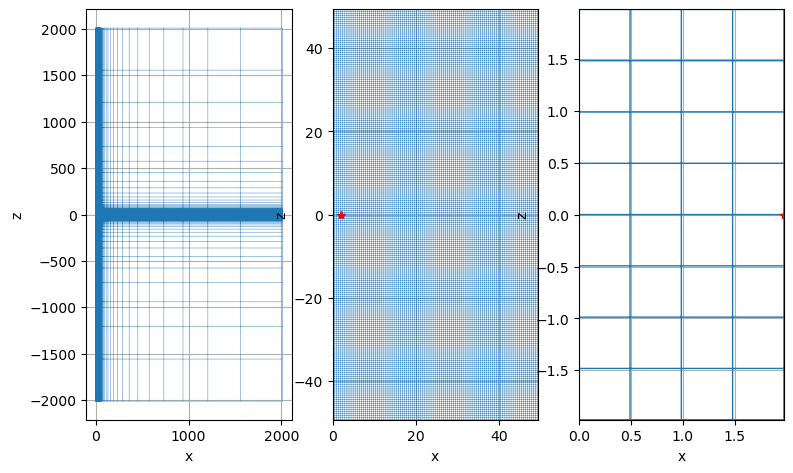

In [4]:
fig, ax = plt.subplots(1,3, figsize=(9,7))
ax[0] = mesh.plot_grid(ax=ax[0], show_it=False, linewidth=0.3)  
ax[0].set_aspect('equal')
ax[1] =  mesh.plot_grid(ax=ax[1], show_it=False, linewidth=0.3)
#ax[1] =  mesh.plot_grid(show_it=True)
ax[1].set_xlim(0., ncx*csx)
ax[1].set_ylim(-ncz*csz , ncz*csz )
ax[1].set_aspect('equal')
ax[1].plot(tx_radius,0,'r*')
ax[2] =  mesh.plot_grid(ax=ax[2], show_it=False, linewidth=1.0)
ax[2].set_xlim(0.,tx_radius)
ax[2].set_ylim(-tx_radius,tx_radius)
ax[2].set_aspect('equal')
ax[2].plot(tx_radius,0,'r*')


## Plot model 

In [5]:
sigma_air = 1e-8
sigma_sea = 3.3
thick_sea = 1000.1
depth_seabed = 15.0
sigma_seabed = 1.0
sigma_target = 5.0
rc_block = 0
rd_mound = 30.
zh_mound = 15.
zd_mound = 15.
slope_mound = 3./5.
#tx_height = 0.5
tx_current = 1

## Set Up mapping

In [6]:
ind_active = (
    (mesh.cell_centers[:, 2] < -tx_height ) &
    ((mesh.cell_centers[:, 2] < -tx_height - zh_mound) |
    ((mesh.cell_centers[:, 2] - (-tx_height - zh_mound)) < (-slope_mound * (mesh.cell_centers[:, 0] - rd_mound))))
)


In [7]:
ind_mound_top = (mesh.cell_centers[ind_active][:, 2] > -(tx_height + zh_mound))

ind_mound_bot = (
    (mesh.cell_centers[ind_active][:, 2] <= -(tx_height + zh_mound)) &
    (mesh.cell_centers[ind_active][:, 2] > -(tx_height + zh_mound+ zd_mound)) &
    ((mesh.cell_centers[ind_active][:, 2] - (-tx_height - zh_mound)) > (slope_mound * (mesh.cell_centers[ind_active][:, 0] - rd_mound)))
)

# ind_seabed = (
#     (mesh.cell_centers[ind_active][:, 2] <= -(tx_height + zh_mound)) &
#     ((mesh.cell_centers[ind_active][:, 2] - (-tx_height - zh_mound)) <= (slope_mound * (mesh.cell_centers[ind_active][:, 0] - rd_mound)))
# )

ind_seabed = ~ind_mound_top & ~ind_mound_bot

In [8]:
print(mesh.n_cells)
print(ind_active.sum())
print(ind_mound_top.sum())
print(ind_mound_bot.sum())
print(ind_seabed.sum())

31752
13025
1055
1106
10864


In [9]:
## 
indices_list = [ind_mound_top, ind_mound_bot, ind_seabed]
active_map = maps.InjectActiveCells(mesh= mesh,
             indActive=ind_active, valInactive=np.log(sigma_sea))
projection_map = maps.SurjectUnits(indices_list)
## Kill indices for the seawater

## Exponential map to convert the model to conductivity
exp_map = maps.ExpMap(mesh)
model_map = exp_map*active_map *  projection_map
#model_map = exp_map*active_map *  parametric_map

In [10]:
# model_ref   = np.r_[np.log(sigma_sea) , np.log(sigma_sea), rc_block, rd_block, 0 , 2.*np.pi, zc_block, zd_block]
# model_block = np.r_[np.log(sigma_seabed), np.log(sigma_target), rc_block, rd_block, 0 , 2.*np.pi, zc_block, zd_block]
model_ref= np.log(np.r_[sigma_sea, sigma_sea, sigma_sea])
model_block = np.log(np.r_[sigma_target,sigma_target,  sigma_seabed])

sigma_ref = model_map * model_ref
sigma_block = model_map * model_block
#model = np.r_[sigma_seabed, 2, rc_block, rd_block, 0 , 2.*np.pi, zc_block, zd_block]

In [11]:
print(projection_map.shape)
print(indices_list)

(13025, 3)
[array([False, False, False, ...,  True,  True,  True]), array([False, False, False, ..., False, False, False]), array([ True,  True,  True, ..., False, False, False])]


In [12]:
def plot_two_model(model_1, model_2, range_x = [-40.,40.], range_y = [-40.,20.],
                   vmin=None, vmax=None, ax=None):
    if ax is None: 
        fig, ax = plt.subplots(1,2, figsize=(8,5))
    view="sigma"
    min_field, max_field = None, None
    mirror_data=None
    v_type = "CC"
    view_type="real"  
    plot_me_1 = model_map * model_1
    plot_me_2 = model_map * model_2
    
    if vmin is None:
        vmin = min(np.r_[plot_me_1, plot_me_2])
    if vmax is None:
        vmax = max(np.r_[plot_me_1, plot_me_2])
    norm = LogNorm(vmin=vmin, vmax=vmax)
    cb = plt.colorbar(mesh.plot_image(
        plot_me_1, v_type= v_type, view=view_type, 
        range_x=range_x, range_y=range_y,
        pcolor_opts={'norm': norm}, stream_opts= {'color': 'w'}, 
        stream_threshold=min_field, mirror=True, ax=ax[0], 
    )[0], ax=ax[0])
    cb.set_label(view) 
    cb = plt.colorbar(mesh.plot_image(
        plot_me_2, v_type= v_type, view=view_type, 
        range_x=range_x, range_y=range_y,
        pcolor_opts={'norm': norm}, stream_opts= {'color': 'w'}, 
        stream_threshold=min_field, mirror=True, ax=ax[1], 
    )[0], ax=ax[1])
    cb.set_label(view) 
    for a in ax:
        a.plot([-tx_radius,tx_radius],[0,0],'r*-')
        a.set_aspect('equal')
        a.set_xlabel("x (m)")
        a.set_ylabel("z (m)")
    return ax


In [13]:
def plot_mound_outline(ax,x_range=[-50., 50.]):
    x_mound_top= np.max(np.r_[0, rd_mound- zh_mound/slope_mound])
    x_mound_bot= np.max(np.r_[0, rd_mound- zd_mound/slope_mound])

    x_top = np.r_[x_range[0],-rd_mound, -x_mound_top, x_mound_top, rd_mound, x_range[1]]
    z_top = np.r_[0         ,        0,     zh_mound,    zh_mound,        0,          0] -tx_height-zh_mound
    x_bot = np.r_[x_range[0],-rd_mound, -x_mound_bot, x_mound_bot, rd_mound, x_range[1]]
    z_bot = np.r_[0         ,        0,    -zd_mound,   -zd_mound,        0,          0] -tx_height-zh_mound
    ax.plot(x_top, z_top, color='k', linestyle= '--', lw=1.)
    ax.plot(x_bot, z_bot, color='k', linestyle= '--', lw=1.)
    ax.plot(x_range, np.zeros_like(x_range)-tx_height-zh_mound, color='k', linestyle= '--', lw=1.)
    return ax


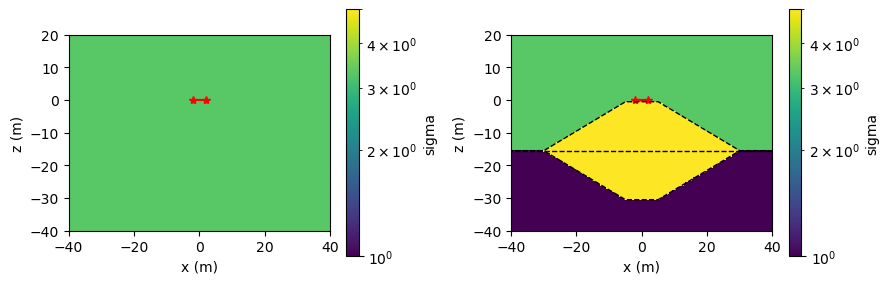

In [14]:
fig, ax = plt.subplots(1,2, figsize=(9,3))
plot_two_model(model_1=model_ref, model_2=model_block,ax=ax)
plot_mound_outline(ax[1])
plt.tight_layout()

## Define Time steps

ramp time 200 $ \mu $ sec    
K. Nakayama, 2016, Practical marine TDEM systems using ROV for the ocean bottom hydrothermal deposits, Techno-Ocean Kobe, Japan, 2016

In [27]:
time_steps = [(2e-6,  150),  (5e-6,  150),  (2e-5,  150), (5e-5,  20)]
tstrt, tend = 1e-4, 4e-3

steps = np.array([])
for i in range(len(time_steps)):
    dt, n = time_steps[i]
    step_array = dt * np.ones(n)
    steps = np.concatenate((steps, step_array))
time_clc = np.cumsum(steps)
rmp_time = 200e-6
time_clc = time_clc[time_clc < rmp_time + tend+eps ]

In [28]:
## define time to recorded at receiver
#time_rec = np.logspace(np.log10(1e-5), np.log10(1e-2), 31)
time_rec = 10**(np.arange(np.log10(1e-4), np.log10(4e-3), 0.1))


In [29]:
waveform=tdem.sources.RampOffWaveform(off_time=rmp_time)

rx_z = tdem.receivers.PointMagneticFluxTimeDerivative(
    np.r_[0, 0, 0], times=time_rec +rmp_time, orientation="z"
)
src = tdem.sources.CircularLoop(
    location=np.r_[0, 0, 0], radius=tx_radius, receiver_list=[rx_z],
    waveform=waveform, n_turns=5,
)
survey = tdem.Survey([src])
sim = tdem.simulation.Simulation3DElectricField(
    mesh=mesh, survey=survey,  solver=Pardiso, time_steps=time_steps,
    sigmaMap=model_map
)


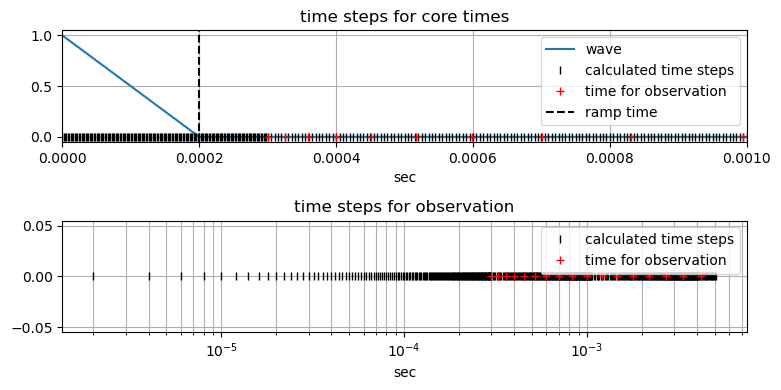

In [30]:
fig, ax = plt.subplots(2,1,figsize=(8,4))
ax[0].plot(sim.times, [waveform.eval(t) for t in sim.times],label='wave')
ax[0].plot(sim.times, np.zeros_like(sim.times), "|k",label='calculated time steps')
ax[0].plot(time_rec+rmp_time, np.zeros_like(time_rec), "+r",lw=3,label='time for observation')
ax[0].axvline(rmp_time, color='k', linestyle='--',label='ramp time')
ax[0].set_xlim(0,1e-3)#time_steps[0][0]*time_steps[0][1])
ax[0].set_title('time steps for core times')

ax[1].semilogx(sim.times, np.zeros_like(sim.times), "|k",label='calculated time steps')
ax[1].semilogx(time_rec+rmp_time, np.zeros_like(time_rec), "+r",lw=3,label='time for observation')
ax[1].set_title('time steps for observation')

for a in ax:
    a.grid(which='both')
    a.set_xlabel('sec')
    a.legend()
plt.tight_layout()
plt.show()

## Get observation from forwad simulation

In [31]:
sim_block =sim.dpred(model_block)
sim_ref = sim.dpred(model_ref)
dobs_block = -sim_block*np.pi*tx_radius**2
dobs_ref = -sim_ref*np.pi*tx_radius**2


In [79]:
relative_error = 0.01
noise_floor_dobs =  1e-7
noise_floor = noise_floor_dobs/(np.pi*tx_radius**2)
np.random.seed(0)
sim_block_noisy = (sim_block +
     np.random.randn(len(sim_block)) * relative_error * np.abs(sim_block) +
     np.random.randn(len(sim_block)) * noise_floor 
     )
dobs_block_noisy = -sim_block_noisy*np.pi*tx_radius**2

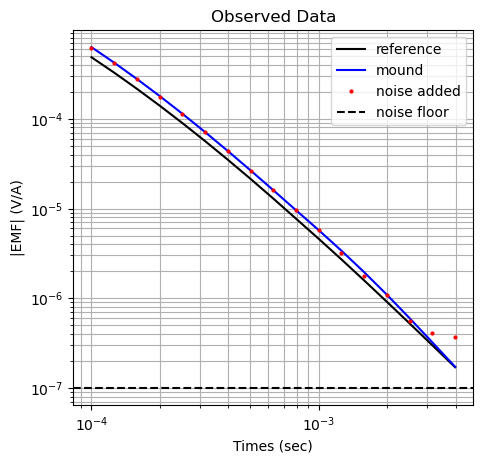

In [82]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax.loglog(time_rec, np.abs(dobs_ref), "k-", markersize=2 , label='reference')
ax.loglog(time_rec, np.abs(dobs_block), "b-", markersize=2, label='mound')
ax.loglog(time_rec, np.abs(dobs_block_noisy), "ro", markersize=2, label='noise added')
# Draw horizontal line
ax.axhline(y=noise_floor_dobs, linestyle='--', color='k', label='noise floor')

ax.legend()
ax.grid(which="both")
ax.set_xlabel("Times (sec)")
ax.set_ylabel("|EMF| (V/A)")
ax.set_title("Observed Data")


## Assign uncertainties

In [34]:
# # 1% of the absolute value

# uncertainties = 0.01 * np.abs(sim_block) * np.ones(np.shape(sim_block))
# print(uncertainties)

## Defining The data

In [35]:

#data_object = data.Data(survey, dobs=dobs_noisy, standard_deviation=uncertainties)

data_object = data.Data(survey, dobs=sim_block_noisy,
     relative_error=relative_error, noise_floor=noise_floor)

## Starting/Reference model

In [36]:
# # Starting model is log-conductivity values (S/m)
# starting_conductivity_model = model_ref

# # Reference model is also log-resistivity values (S/m)
# reference_conductivity_model = starting_conductivity_model.copy()

In [37]:
simulation_L2 = tdem.simulation.Simulation3DElectricField(
    mesh=mesh, survey=survey,  solver=Pardiso, time_steps=time_steps,
    sigmaMap=model_map,
)

## Data Misfit

In [38]:
dmis_L2 = data_misfit.L2DataMisfit(simulation=simulation_L2, data=data_object)

## Regularization

In [39]:
# Smoothest inversion
#alpha_s = 1
# alpha_x = 1
# alpha_y = 1
# alpha_z = 1

#reg_s = regularization.Smallness(mesh=mesh,mapping=model_map, reference_model= model_ref)
#reg_s = regularization.Smallness(mesh=mesh,reference_model= sigma_ref)

# reg_x = regularization.SmoothnessFirstOrder(mesh, orientation="x")
# reg_y = regularization.SmoothnessFirstOrder(mesh, orientation="y")
# reg_z = regularization.SmoothnessFirstOrder(mesh, orientation="z")

# reg_L2 = alpha_s * reg_s + alpha_x * reg_x + alpha_y * reg_y + alpha_z * reg_z
#reg_L2 = alpha_s * reg_s 
reg_L2 = regularization.Smallness(mesh=discretize.TensorMesh([3]))

# Optimization

In [40]:
maxIter, maxIterCG, maxIterLS = 10,50,10
opt_L2 = optimization.ProjectedGNCG(
            maxIter=maxIter, lower=np.r_[-np.inf,-np.inf,-np.inf],
            upper=np.r_[np.inf,np.inf,np.inf],
        maxIterCG=maxIterCG, maxIterLS=maxIterLS,
)

## Inverse Problem

In [41]:
#target_misfit = directives.TargetMisfit(chifact=0.5)
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

## Inversion Directives

In [42]:
# update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1)
beta_schedule = directives.BetaSchedule(coolingFactor=3.0, coolingRate=1)
target_misfit = directives.TargetMisfit(chifact=0.5)
save = directives.SaveOutputDictEveryIteration()
directives_list_L2 = [starting_beta, beta_schedule, target_misfit, save]


## Define and Run Inversion

In [43]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)


In [44]:
# Run the inversion
recovered_model_L2 = inv_L2.run(model_ref)
#recovered_model_L2 = inv_L2.run(sigma_ref)


Running inversion with SimPEG v0.22.0
simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DElectricField problem***
                        


c:\Users\81805\anaconda3\envs\env_ubcgif\lib\site-packages\pymatsolver\direct.py:23: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format.
  self.solver = MKLPardisoSolver(
c:\Users\81805\anaconda3\envs\env_ubcgif\lib\site-packages\pymatsolver\direct.py:73: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format.
  self.solver.refactor(self.A)


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.00e+04  3.93e+03  0.00e+00  3.93e+03    1.45e+04      0              
   1  1.33e+04  6.20e+02  2.44e-02  9.46e+02    5.89e+03      0              
   2  4.45e+03  8.94e+01  4.32e-02  2.82e+02    2.19e+03      0   Skip BFGS  
   3  1.48e+03  2.58e+01  5.03e-02  1.00e+02    7.72e+02      0   Skip BFGS  
   4  4.94e+02  1.83e+01  5.28e-02  4.44e+01    2.63e+02      0   Skip BFGS  
   5  1.65e+02  1.74e+01  5.37e-02  2.63e+01    8.83e+01      0   Skip BFGS  
   6  5.49e+01  1.72e+01  5.47e-02  2.02e+01    2.97e+01      0   Skip BFGS  
   7  1.83e+01  1.67e+01  5.99e-02  1.78e+01    1.06e+01      0   Skip BFGS  
   8  6.10e+00  1.60e+01  8.66e-02  1.65e+01    5.70e+00      0   Skip BFGS  
   9  2.03e+00  1.51e+01

In [50]:
betas  = [save.outDict[i]["beta"]  for i in save.outDict.keys()]
phi_d  = [save.outDict[i]["phi_d"] for i in save.outDict.keys()]
phi_m  = [save.outDict[i]["phi_m"] for i in save.outDict.keys()]
models = [save.outDict[i]["m"]     for i in save.outDict.keys()]
fobj   = [save.outDict[i]["f"]     for i in save.outDict.keys()]
sim_models  = [save.outDict[i]["dpred"] for i in save.outDict.keys()]

In [57]:
dobs_models = {}
for i in range(len(models)):
    dobs_models[i] = -sim_models[i]*np.pi*tx_radius**2


In [51]:
def plot_tikhonov_curves(betas, phi_d, phi_m, phid_star=None, iteration=None, ax=None): 
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5,3))
    ax.loglog(phi_m, phi_d)
    if phid_star is not None: 
        ax.loglog(phi_m, np.ones_like(phi_m) * phid_star, "--k", label="$\phi_d^*$")
    if iteration is not None: 
        ax.loglog(phi_m[iteration], phi_d[iteration], "C3o", label=f'beta={betas[iteration]:1.1e}')
    ax.set_ylabel("$\\phi_d$")
    ax.set_xlabel("$\\phi_m$")
    ax.set_title("Tikhonov Curve")
    ax.legend()
    ax.grid()
    plt.tight_layout()
    return ax


In [59]:
def plot_data(dobs_models, iteration,y_bottom=1e-7, ax=None):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5,3))
    ax.loglog(time_rec, dobs_ref, "k-", label="data of reference model")
    ax.loglog(time_rec, dobs_block_noisy, "r-", label='Observation')
    ax.loglog(time_rec, dobs_models[iteration], "b.", label=f'estimation, iter={iteration}')
    ax.set_ylim(bottom=y_bottom)
    ax.legend()
    ax.grid(True, which="both")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("EMF (V/A)")
    ax.set_title("Data plot")
    plt.tight_layout()
    return ax

In [60]:
def plot_inversion_results(ind_show, phid_star=len(dobs_block_noisy),vmin=None,vmax=None,ax=None):
    if ax is None:
        fig, ax = plt.subplots(2,2,figsize=(12, 8))
    [ax[0,0],ax[1,0]] = plot_two_model(model_1=model_block, model_2=models[ind_show],
                   vmin=vmin,vmax=vmax, ax=[ax[0,0],ax[1,0]])
    ax[0,0]=plot_mound_outline(ax[0,0])
    ax[1,0]=plot_mound_outline(ax[1,0])
#    plot_data(dobs_ref=dobs_ref, dobs_models=dobs_models, iteration=ind_show, ax=ax[0,1])
    plot_data(dobs_models=dobs_models, iteration=ind_show, ax=ax[0,1])
    plot_tikhonov_curves(betas=betas, phi_d=phi_d, phi_m=phi_m,
            phid_star=phid_star, iteration=ind_show, ax=ax[1,1])
    ax[0,0].set_title('True model')
    ax[1,0].set_title('Estimated model')
    plt.tight_layout()
    return ax

In [61]:
def plot_inversion_results_widgets(ind_show=0):
    fig, ax = plt.subplots(2,2,figsize=(12, 8),dpi=300)
    vmin, vmax = 0.8, 6
    plot_inversion_results(vmin=vmin,vmax=vmax,ind_show=ind_show,ax=ax)

ipywidgets.interact(
    plot_inversion_results_widgets,
    ind_show=ipywidgets.IntSlider(min=0, max=len(models)-1, value=0, continuous_update=False)
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='ind_show', max=9), Output()), _…

<function __main__.plot_inversion_results_widgets(ind_show=0)>

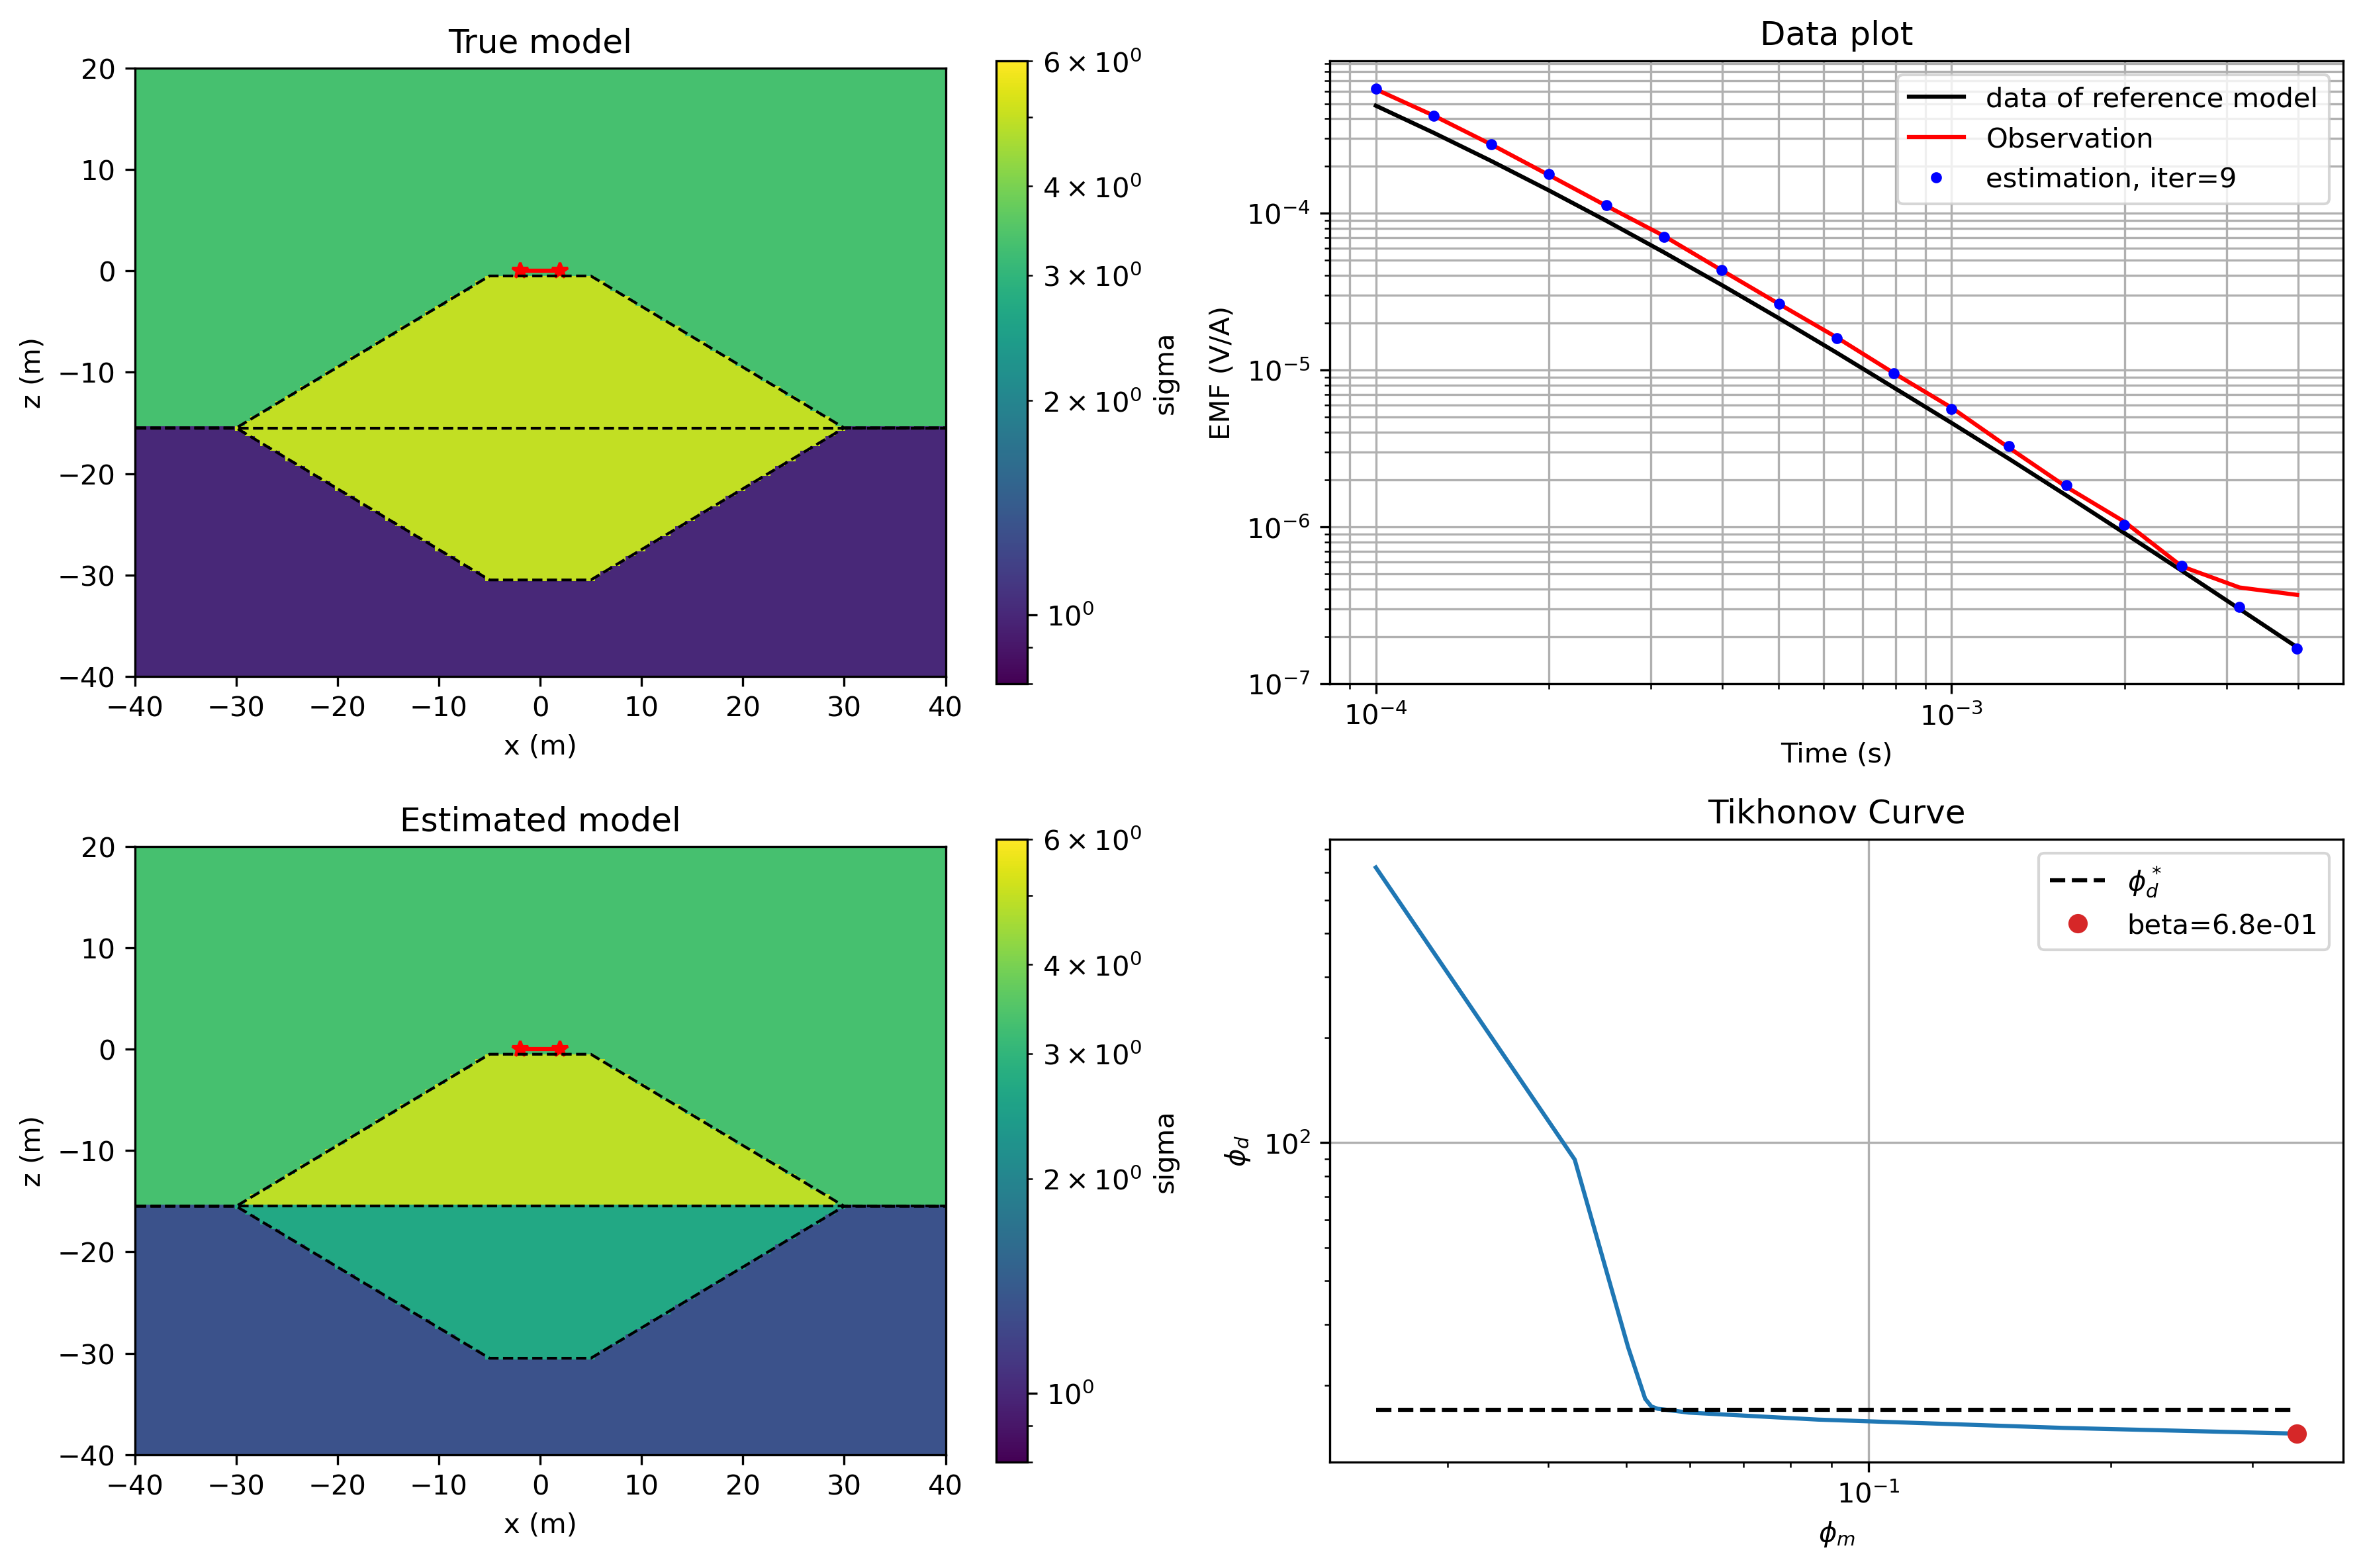

In [89]:
plot_inversion_results_widgets(len(models)-1)
plt.savefig("44_inversion_mound_rmp_overfit.png", dpi=300)

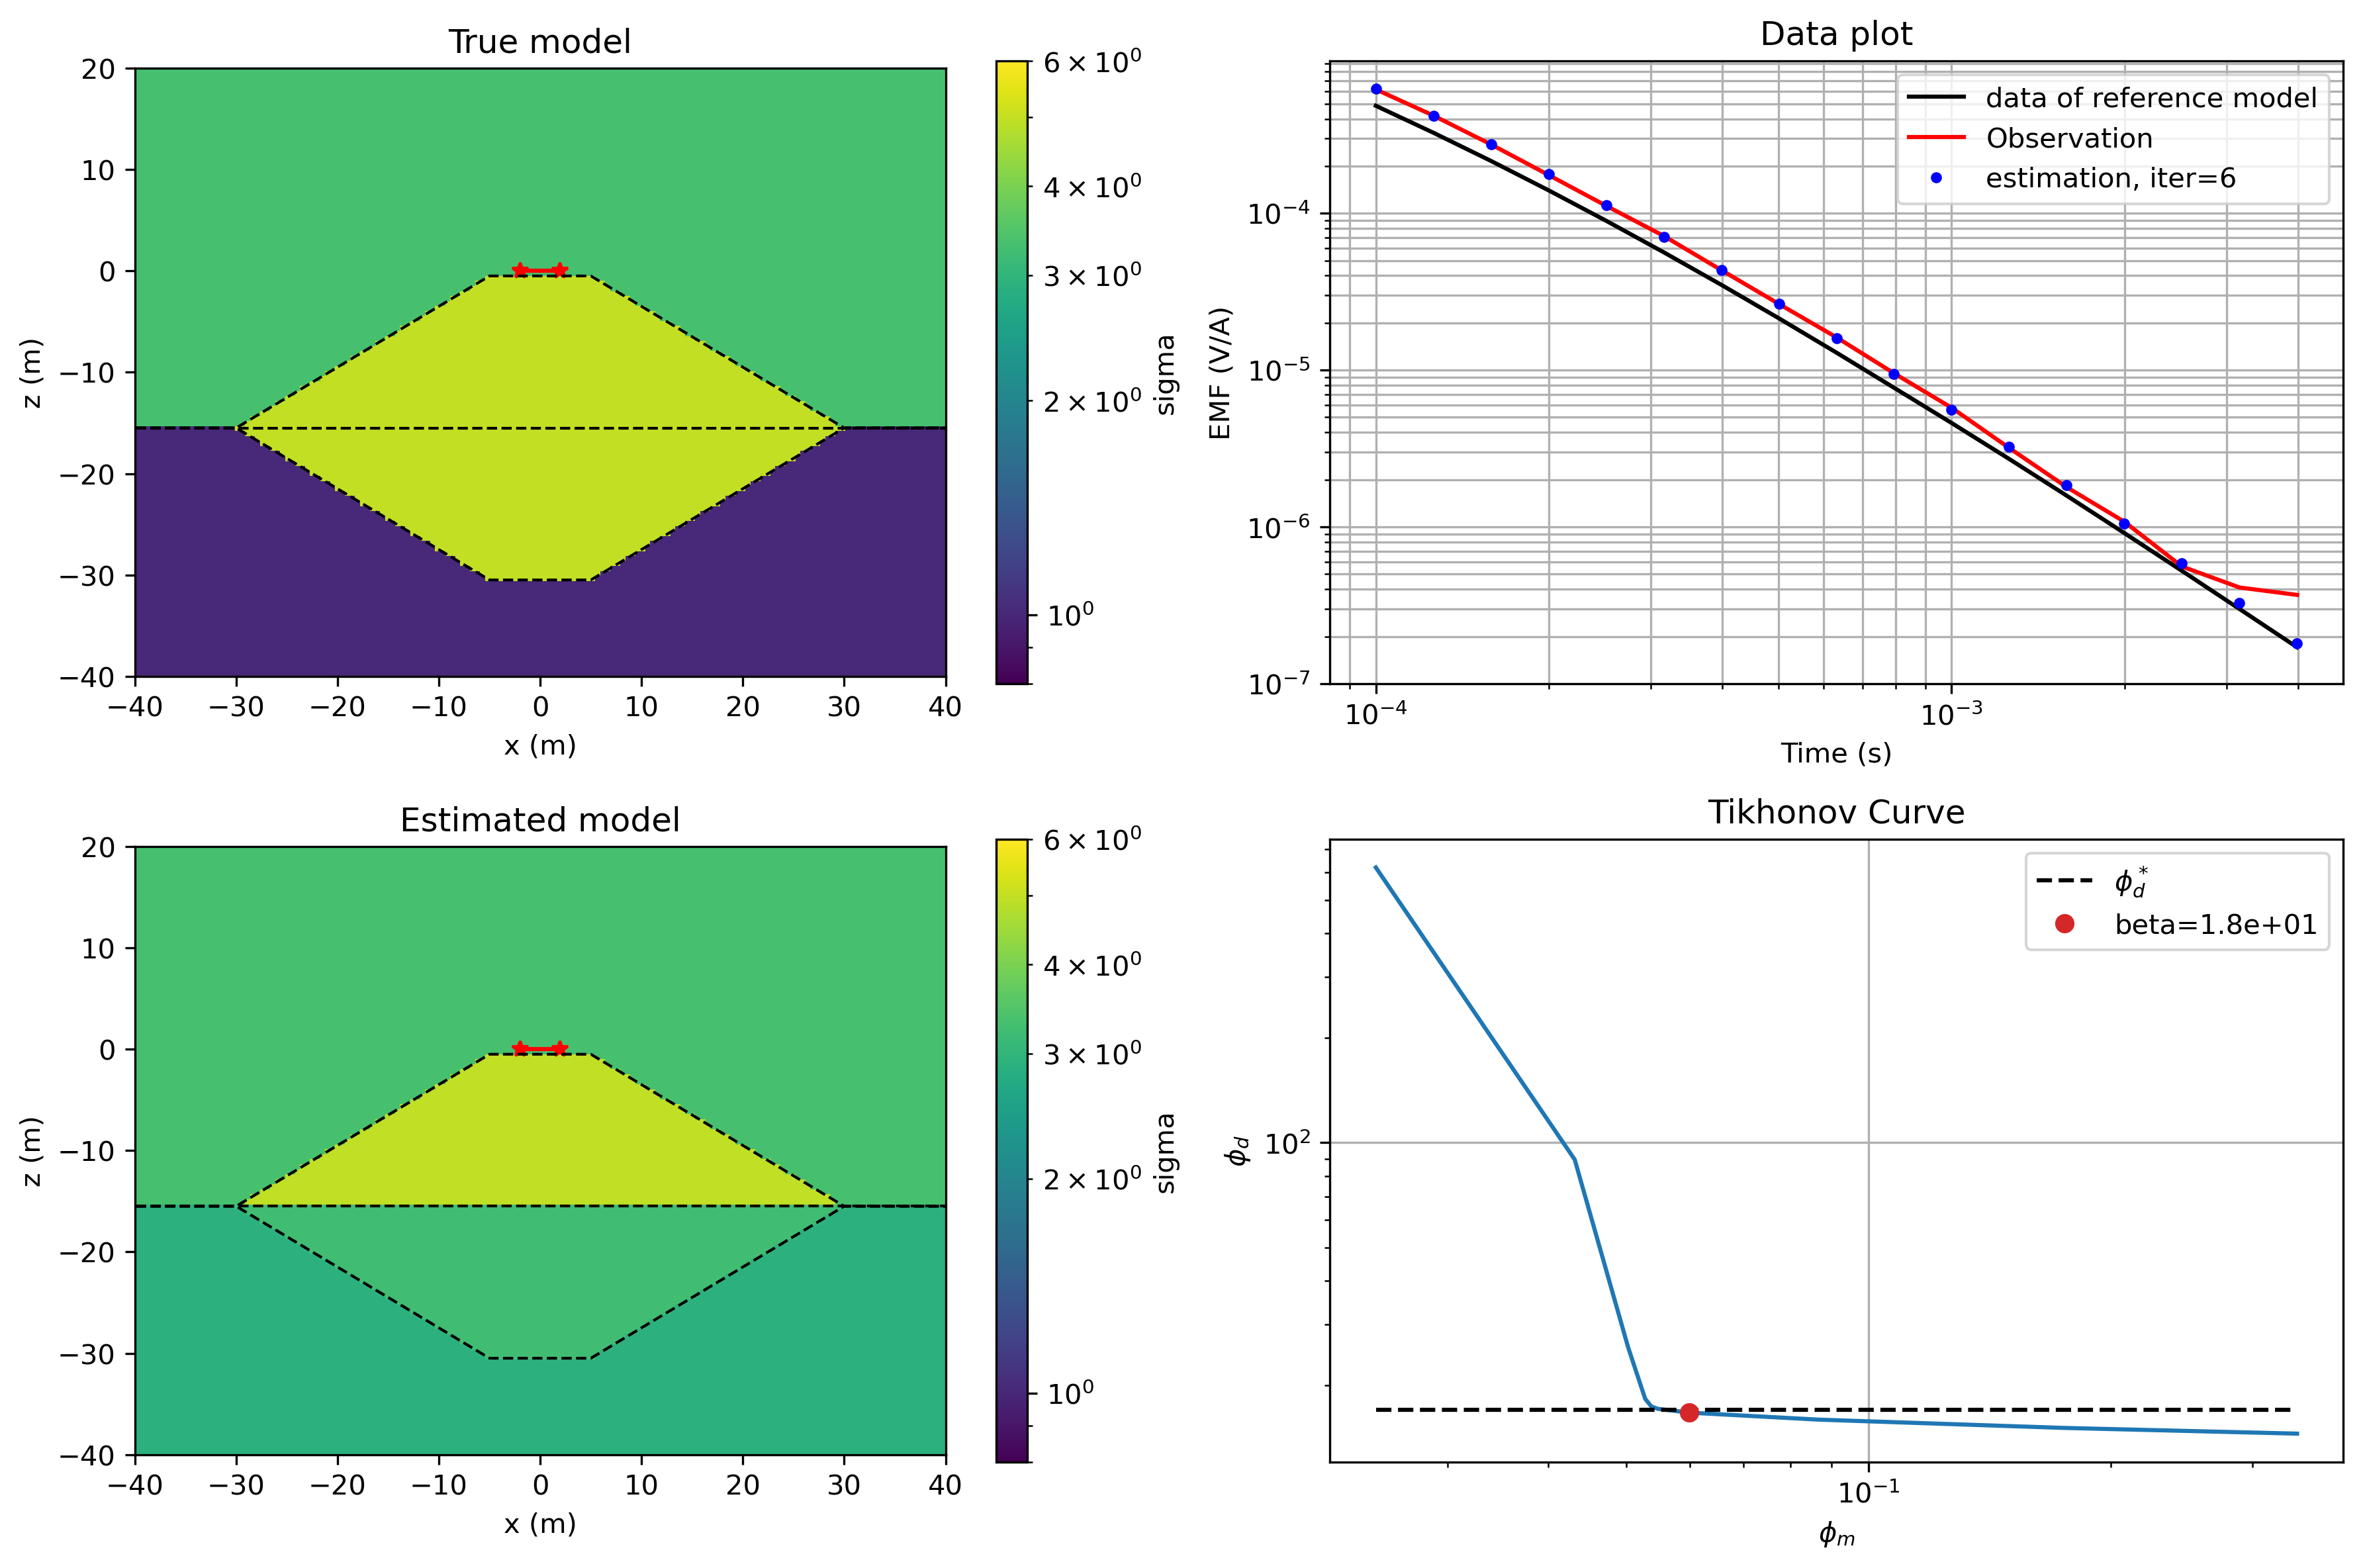

In [88]:
plot_inversion_results_widgets(6)
plt.savefig("44_inversion_mound_rmp_acceptable.png", dpi=300)

In [64]:
def save_all_fields_images(index_list, output_folder='images'):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for ind_save in index_list:
        # Create a new figure and axes for each time index
        fig, ax = plt.subplots(2,2,figsize=(12, 8),dpi=300)
        
        # Plot the fields for the current time index
        vmin, vmax = 0.8, 6
        plot_inversion_results(vmin=vmin,vmax=vmax,ind_show=ind_save,ax=ax)

        # Create a filename with zero padding (e.g., 001.png, 002.png)
        filename = f'{ind_save:03d}.png'
        # Save the figure to the output folder
        filepath = os.path.join(output_folder, filename)
        plt.savefig(filepath, format='png', dpi=300, bbox_inches='tight', pad_inches=0.1)
        
        # Close the figure to avoid display issues and free up memory
        plt.close(fig)

In [65]:
index_list = np.arange(len(models))
output_folder = 'images'
save_all_fields_images(index_list, output_folder= output_folder)


In [66]:
def images_to_gif(image_folder, output_gif, duration=1000, resize=(320, 240)):
    # Get all the image files in the folder
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.png') or f.endswith('.jpg')])

    # Open and resize the images
    images = [Image.open(os.path.join(image_folder, img)).resize(resize, Image.Resampling.LANCZOS) for img in image_files]
    
    # Save the images as an animated GIF
    images[0].save(output_gif, save_all=True, append_images=images[1:], optimize=False, duration=duration, loop=0)


In [87]:
# Provide the path to the input image folder, output video file, and desired duration (slower)
input_folder = r"images"
output_file = r"44_Inversion_mound_rmp.gif"
duration = 1000  # 1000 ms per frame (1 second per frame)
resize = (1200, 800)  # New resolution (width, height)

# Call the function to convert the images to a GIF
images_to_gif(image_folder=input_folder, output_gif=output_file, duration=duration, resize=resize)

In [46]:
def delete_all_images(folder_path):
    # Check if the folder exists
    if not os.path.exists(folder_path):
        raise ValueError(f"The folder {folder_path} does not exist.")
    
    # Get the list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
    
    # Delete each image file
    for image_file in image_files:
        file_path = os.path.join(folder_path, image_file)
        try:
            os.remove(file_path)
            print(f"Deleted {file_path}")
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")

# Provide the path to the folder containing images
image_folder = 'images'

# Call the function to delete all images in the folder
delete_all_images(image_folder)

Deleted images\000.png
Deleted images\001.png
Deleted images\002.png
Deleted images\003.png
Deleted images\004.png
Deleted images\005.png
Deleted images\006.png
Deleted images\007.png
Deleted images\008.png
Deleted images\009.png
